In [1]:
 pip install transformers timm datasets rouge-score nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 230.2 MB/s eta 0:00:01^C:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 230.2 MB/s eta 0:00:01Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers timm datasets rouge-score nltk huggingface-hub

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set paths
DATA_DIR = "/kaggle/input/custom-captions-dataset/custom_captions_dataset"
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_dir, tokenizer, transform, max_length=50):
        self.data = dataframe
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        caption = row['caption']
        tokens = self.tokenizer(caption, padding='max_length', max_length=self.max_length,
                                truncation=True, return_tensors='pt')
        return image, tokens.input_ids.squeeze(0), tokens.attention_mask.squeeze(0)

In [5]:
import torch.nn as nn
from transformers import ViTModel, GPT2LMHeadModel, GPT2Tokenizer

class ImageCaptionModel(nn.Module):
    def __init__(self, vit_model='WinKawaks/vit-small-patch16-224', decoder_model='gpt2'):
        super().__init__()
        self.encoder = ViTModel.from_pretrained(vit_model)
        self.decoder = GPT2LMHeadModel.from_pretrained(decoder_model)
        self.encoder_proj = nn.Linear(self.encoder.config.hidden_size, self.decoder.config.n_embd)

    def forward(self, images, input_ids, attention_mask):
        # ViT encoding
        encoder_outputs = self.encoder(images).last_hidden_state.mean(dim=1)
        encoder_embeds = self.encoder_proj(encoder_outputs).unsqueeze(1)
    
        # Decoder embedding
        decoder_inputs = self.decoder.transformer.wte(input_ids)
        decoder_inputs = torch.cat([encoder_embeds, decoder_inputs], dim=1)
    
        # Adjust attention
        extended_attention_mask = torch.cat([
            torch.ones((attention_mask.size(0), 1), device=attention_mask.device),
            attention_mask
        ], dim=1)
    
        # Fix labels to match added token
        labels = torch.cat([
            torch.full((input_ids.size(0), 1), tokenizer.pad_token_id, device=input_ids.device),
            input_ids
        ], dim=1)
    
        outputs = self.decoder(inputs_embeds=decoder_inputs,
                               attention_mask=extended_attention_mask,
                               labels=labels)
        return outputs

2025-04-14 12:21:21.643031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744633281.860378      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744633281.924560      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
from transformers import GPT2Tokenizer
import torch.optim as optim

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Important for GPT-2

# Datasets
train_dataset = ImageCaptionDataset(train_df, os.path.join(DATA_DIR, 'train'), tokenizer, transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Model
model = ImageCaptionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Training loop
def train_model(model, dataloader, optimizer, device, epochs=8):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, input_ids, attention_mask in dataloader:
            images, input_ids, attention_mask = images.to(device), input_ids.to(device), attention_mask.to(device)
            outputs = model(images, input_ids, attention_mask)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

train_model(model, train_loader, optimizer, device, epochs=6)

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 2.4796
Epoch 2, Loss: 2.1977
Epoch 3, Loss: 2.0491
Epoch 4, Loss: 1.9197
Epoch 5, Loss: 1.7958
Epoch 6, Loss: 1.6770


In [12]:
import os
from transformers import ViTImageProcessor  # If you used this

# Define save directory
save_dir = "/kaggle/working/image_captioning_components"
os.makedirs(save_dir, exist_ok=True)

# 1. Save model weights
model_path = os.path.join(save_dir, "image_caption_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

# 2. Save encoder (ViT)
encoder_path = os.path.join(save_dir, "encoder")
model.encoder.save_pretrained(encoder_path)
print(f"Encoder saved to {encoder_path}")

# 3. Save decoder (GPT-2)
decoder_path = os.path.join(save_dir, "decoder")
model.decoder.save_pretrained(decoder_path)
print(f"Decoder saved to {decoder_path}")

# 4. Save tokenizer
tokenizer_path = os.path.join(save_dir, "tokenizer")
tokenizer.save_pretrained(tokenizer_path)
print(f"Tokenizer saved to {tokenizer_path}")

# 5. Save processor (if used)
# Only do this if you used a processor like ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")
processor_path = os.path.join(save_dir, "processor")
processor.save_pretrained(processor_path)
print(f"Processor saved to {processor_path}")

Model weights saved to /kaggle/working/image_captioning_components/image_caption_model.pth
Encoder saved to /kaggle/working/image_captioning_components/encoder
Decoder saved to /kaggle/working/image_captioning_components/decoder
Tokenizer saved to /kaggle/working/image_captioning_components/tokenizer


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Processor saved to /kaggle/working/image_captioning_components/processor


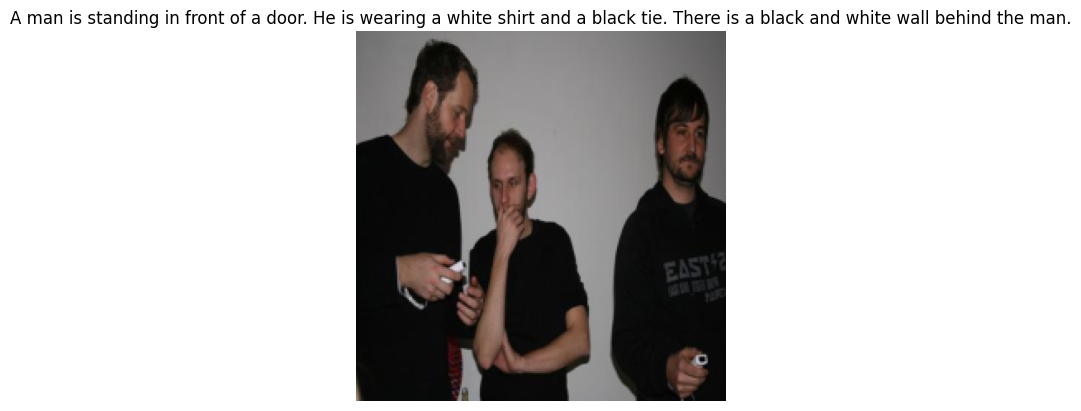

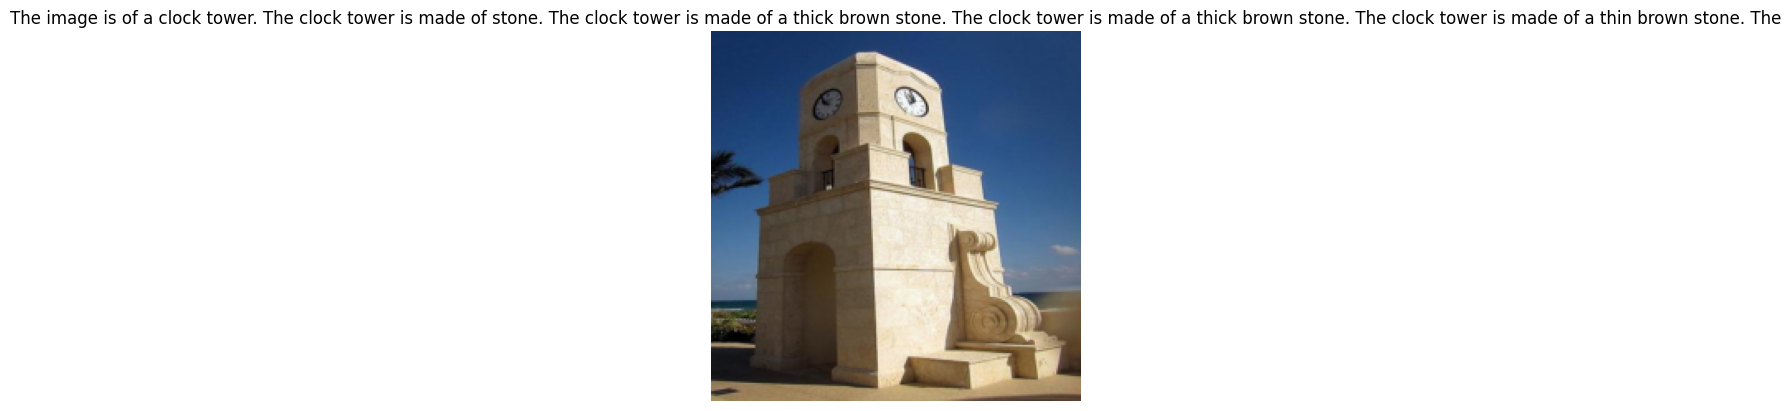

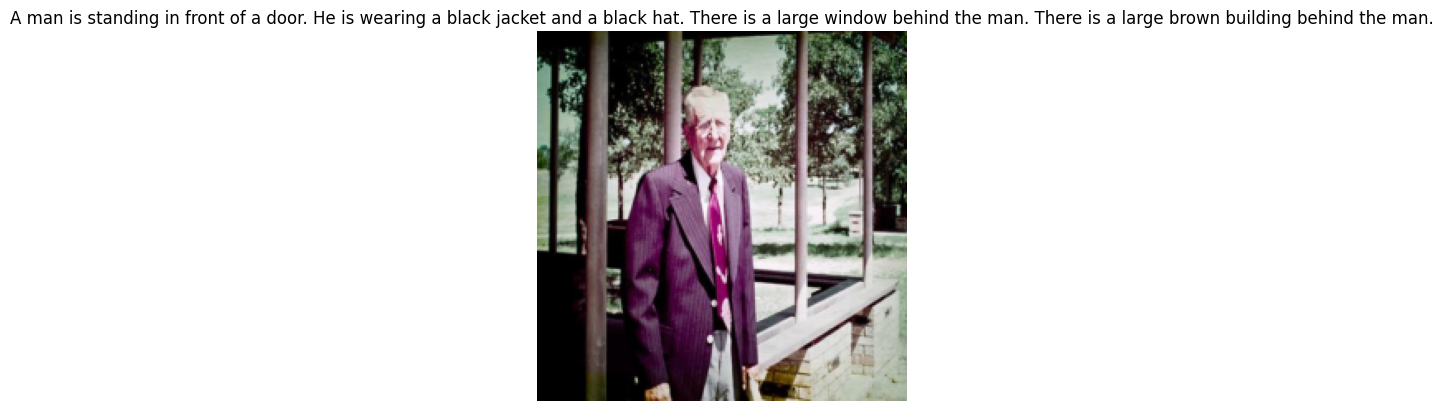

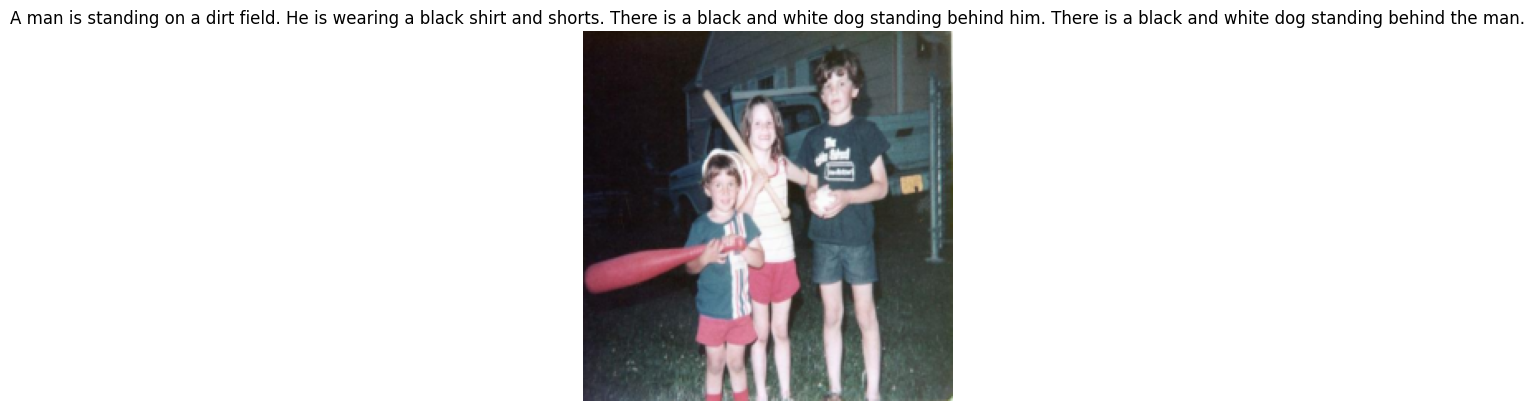

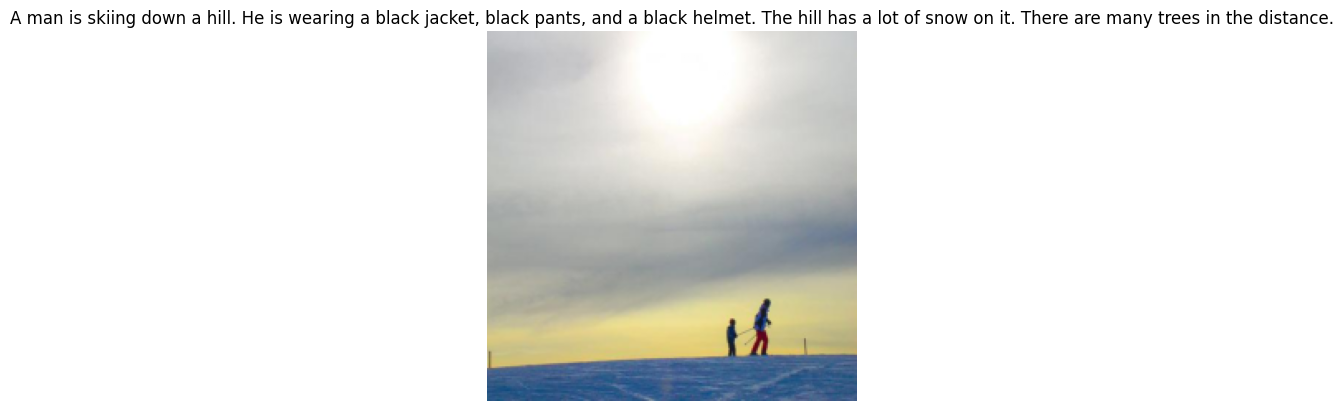

In [13]:
import random
import matplotlib.pyplot as plt
import torch

# Define function to generate captions
def generate_caption(model, image_tensor, tokenizer, max_length=50):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)  # add batch dimension
        encoder_outputs = model.encoder(image_tensor).last_hidden_state.mean(dim=1)
        encoder_embeds = model.encoder_proj(encoder_outputs).unsqueeze(1)

        # Start with BOS token (here, we use eos_token as BOS since GPT2 has no BOS)
        generated = torch.tensor([[tokenizer.eos_token_id]], device=device)
        for _ in range(max_length):
            decoder_input = model.decoder.transformer.wte(generated)
            decoder_input = torch.cat([encoder_embeds, decoder_input], dim=1)

            attention_mask = torch.ones(decoder_input.shape[:2], device=device)
            outputs = model.decoder(inputs_embeds=decoder_input, attention_mask=attention_mask)
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            if next_token.item() == tokenizer.eos_token_id:
                break

            generated = torch.cat((generated, next_token), dim=1)

        caption = tokenizer.decode(generated.squeeze(), skip_special_tokens=True)
        return caption.strip()

# Load validation set sample
val_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
VAL_IMG_DIR = os.path.join(DATA_DIR, 'test')
sample_df = val_df.sample(5).reset_index(drop=True)
sample_dataset = ImageCaptionDataset(sample_df, VAL_IMG_DIR, tokenizer, transform)

# Generate and display captions
for i in range(5):
    image_tensor, _, _ = sample_dataset[i]
    caption = generate_caption(model, image_tensor, tokenizer)

    # Convert image tensor back to displayable image
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]

    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()

In [14]:
!pip install nltk rouge-score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=59fdcdf456558ff5db60b0c4fc868587fdbe452e364945b72be7766d6bbdb18e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [15]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [16]:
def evaluate_model(model, dataset, tokenizer, device, max_samples=100):
    model.eval()
    smooth_fn = SmoothingFunction().method4
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    total_bleu = 0
    total_meteor = 0
    total_rougeL = 0
    count = 0

    for i in range(min(max_samples, len(dataset))):
        image_tensor, input_ids, _ = dataset[i]
        image_tensor = image_tensor.to(device)

        # Decode reference and generate caption
        reference = tokenizer.decode(input_ids, skip_special_tokens=True)
        generated = generate_caption(model, image_tensor, tokenizer)

        # Tokenize for evaluation
        ref_tokens = reference.strip().split()
        gen_tokens = generated.strip().split()

        # Compute metrics
        bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smooth_fn)
        meteor = meteor_score([ref_tokens], gen_tokens)  # <-- now properly tokenized
        rougeL = rouge.score(reference, generated)['rougeL'].fmeasure

        total_bleu += bleu
        total_meteor += meteor
        total_rougeL += rougeL
        count += 1

    return {
        'BLEU': total_bleu / count,
        'METEOR': total_meteor / count,
        'ROUGE-L': total_rougeL / count
    }

In [17]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')
test_dataset = ImageCaptionDataset(test_df, TEST_IMG_DIR, tokenizer, transform)
scores = evaluate_model(model, test_dataset, tokenizer, device, max_samples=300)

print("Evaluation Scores:")
print(f"BLEU:     {scores['BLEU']:.4f}")
print(f"METEOR:   {scores['METEOR']:.4f}")
print(f"ROUGE-L:  {scores['ROUGE-L']:.4f}")

Evaluation Scores:
BLEU:     0.0509
METEOR:   0.2327
ROUGE-L:  0.2825


In [18]:
import shutil

# Zip the entire save directory
shutil.make_archive("/kaggle/working/image_captioning_components", 'zip', "/kaggle/working/image_captioning_components")

'/kaggle/working/image_captioning_components.zip'